<a href="https://colab.research.google.com/github/FanZhouVictor/PyTorch-study_ZTM/blob/main/DL_Rct___using_simple_DL__RobustScaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: using dropout to prevent overfitting


# 1. enviroment setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data import

In [3]:

# Load dataset from CSV file
df = pd.read_excel('/content/drive/MyDrive/DL_ Rct/Data/After June 18th 2024/before feature selection/June 18th 2024 _ before Feature selection.xlsx')

df.head()

,real thickness (mm),section feature,Glove type feature,glove surface area (mm^2),manikin surface area (mm^2),distance from hand to glove surface (mm),air temperature (C),air velocity (m/s),relative humidity,Real Rct
0,1.7776,1,1,8172.6226,5739.1526,3.78275,24.62,0.0,63.8,0.139287
1,2.8384,2,1,5636.7413,4662.2734,2.74307,24.62,0.0,63.8,0.111830
2,2.3970,3,1,6306.1881,5113.4392,3.40400,24.62,0.0,63.8,0.158968
3,3.1330,4,1,5656.3951,4715.1019,3.56233,24.62,0.0,63.8,0.147144
4,2.8210,5,1,4962.2504,3523.5967,3.35514,24.62,0.0,63.8,0.118324


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   real thickness (mm)                       1680 non-null   float64
 1   section feature                           1680 non-null   int64  
 2   Glove type feature                        1680 non-null   int64  
 3   glove surface area (mm^2)                 1680 non-null   float64
 4   manikin surface area (mm^2)               1680 non-null   float64
 5   distance from hand to glove surface (mm)  1680 non-null   float64
 6   air temperature (C)                       1680 non-null   float64
 7   air velocity (m/s)                        1680 non-null   float64
 8   relative humidity                         1680 non-null   float64
 9   Real Rct                                  1680 non-null   float64
dtypes: float64(8), int64(2)
memory usage

### change the int to float

In [5]:

# Sample data loading
# df = pd.read_csv('your_dataset.csv')

# Converting 'section_feature' and 'Glove_type' to float64
df['section feature'] = df['section feature'].astype(float)
df['Glove type feature'] = df['Glove type feature'].astype(float)

# Creating the new dataset
new_df = df.copy()

df = new_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   real thickness (mm)                       1680 non-null   float64
 1   section feature                           1680 non-null   float64
 2   Glove type feature                        1680 non-null   float64
 3   glove surface area (mm^2)                 1680 non-null   float64
 4   manikin surface area (mm^2)               1680 non-null   float64
 5   distance from hand to glove surface (mm)  1680 non-null   float64
 6   air temperature (C)                       1680 non-null   float64
 7   air velocity (m/s)                        1680 non-null   float64
 8   relative humidity                         1680 non-null   float64
 9   Real Rct                                  1680 non-null   float64
dtypes: float64(10)
memory usage: 131.4 K

##2.1 Check if there is missing data.

In [6]:
df.isnull().sum()

real thickness (mm)                         0
section feature                             0
Glove type feature                          0
glove surface area (mm^2)                   0
manikin surface area (mm^2)                 0
distance from hand to glove surface (mm)    0
air temperature (C)                         0
air velocity (m/s)                          0
relative humidity                           0
Real Rct                                    0
dtype: int64

#2.2 Seperate the data to independent and dependent variables


In [7]:
feature_columns = df.columns[:-1]  # Assuming the last column is the target
target_column = df.columns[-1]

# Split the data into features and target
X = df[feature_columns]
Y = df[target_column]

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   real thickness (mm)                       1680 non-null   float64
 1   section feature                           1680 non-null   float64
 2   Glove type feature                        1680 non-null   float64
 3   glove surface area (mm^2)                 1680 non-null   float64
 4   manikin surface area (mm^2)               1680 non-null   float64
 5   distance from hand to glove surface (mm)  1680 non-null   float64
 6   air temperature (C)                       1680 non-null   float64
 7   air velocity (m/s)                        1680 non-null   float64
 8   relative humidity                         1680 non-null   float64
dtypes: float64(9)
memory usage: 118.2 KB


In [9]:
Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1680 entries, 0 to 1679
Series name: Real Rct
Non-Null Count  Dtype  
--------------  -----  
1680 non-null   float64
dtypes: float64(1)
memory usage: 13.2 KB


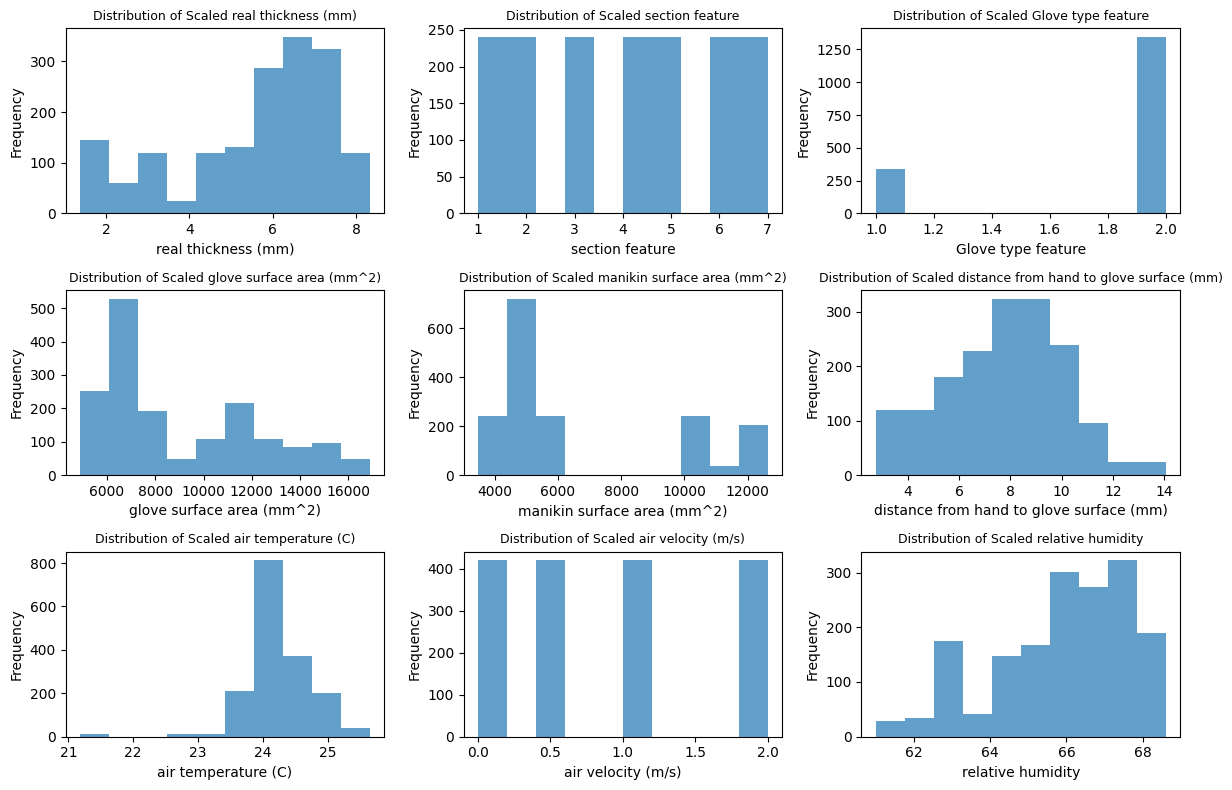

In [10]:
# Plotting the distribution of each feature after scaling
plt.figure(figsize=(12, 8))

for i, column in enumerate(X.columns, 1):
    plt.subplot(3, 3, i)
    plt.hist(X[column], bins=10, alpha=0.7, label=column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Scaled {column}', size = 9)
    #plt.legend()

plt.tight_layout()
plt.show()

##2.3 Using RobusScaler


In [11]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()


X_Scaled = scaler.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns=X.columns)



##2.4 Plot the distribution of the data after RobusScaler

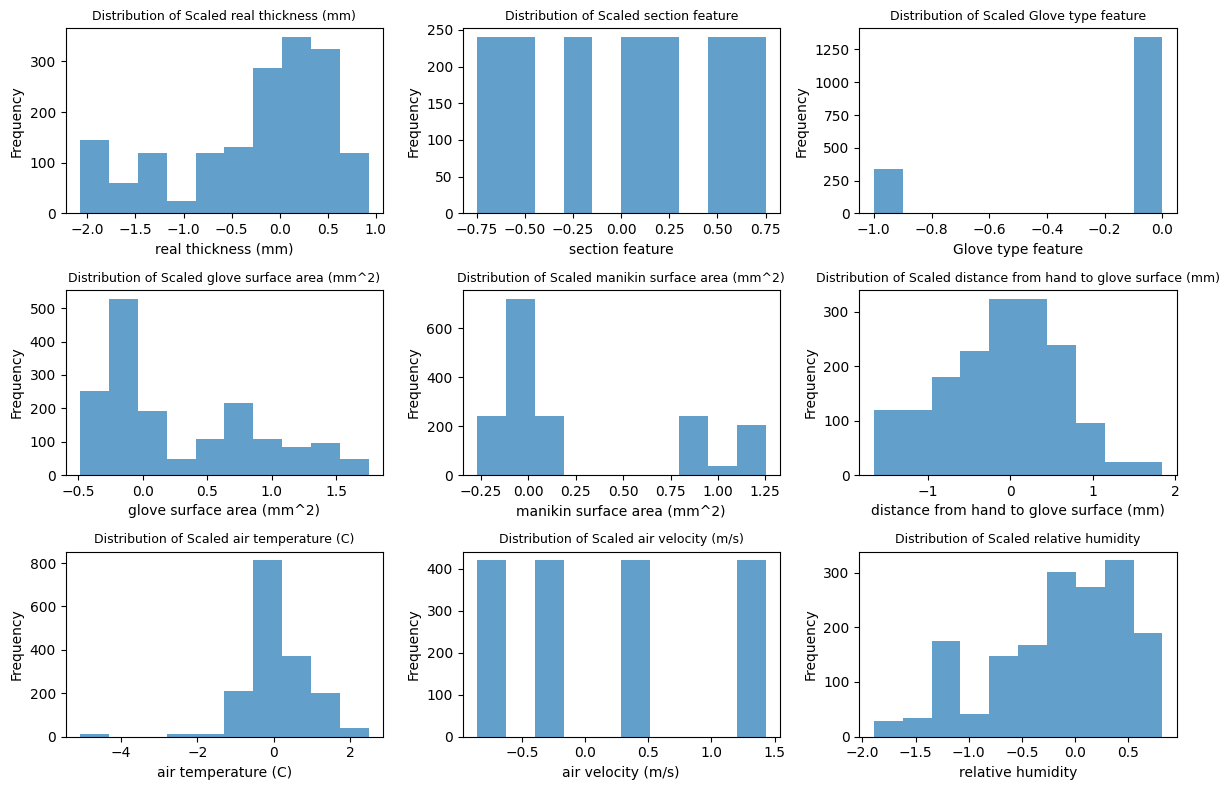

In [12]:
# Plotting the distribution of each feature after scaling
plt.figure(figsize=(12, 8))

for i, column in enumerate(X_Scaled.columns, 1):
    plt.subplot(3, 3, i)
    plt.hist(X_Scaled[column], bins=10, alpha=0.7, label=column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Scaled {column}', size = 9)
    #plt.legend()

plt.tight_layout()
plt.show()

##2.5. Analysis the data characteristics of the variables before and after scalar

###2.5.1. Analysis the data characteristics of the variables before scalar

In [13]:
X_stats = X.describe()
print(X_stats)

       real thickness (mm)  section feature  Glove type feature  \
count          1680.000000      1680.000000         1680.000000   
mean              5.600514         4.000000            1.800000   
std               1.846704         2.000596            0.400119   
min               1.376800         1.000000            1.000000   
25%               4.669900         2.000000            2.000000   
50%               6.182500         4.000000            2.000000   
75%               6.984750         6.000000            2.000000   
max               8.326100         7.000000            2.000000   

       glove surface area (mm^2)  manikin surface area (mm^2)  \
count                1680.000000                  1680.000000   
mean                 9081.410970                  6626.279768   
std                  3237.683782                  3063.628086   
min                  4888.350900                  3476.047300   
25%                  6468.968400                  4676.433300   
50%   

###2.5.2 Analysis the data characteristics for the variable after scaler

In [14]:
X_Scaled_stats = X_Scaled.describe()
print(X_Scaled_stats)

       real thickness (mm)  section feature  Glove type feature  \
count          1680.000000      1680.000000         1680.000000   
mean             -0.251414         0.000000           -0.200000   
std               0.797764         0.500149            0.400119   
min              -2.076031        -0.750000           -1.000000   
25%              -0.653433        -0.500000            0.000000   
50%               0.000000         0.000000            0.000000   
75%               0.346567         0.500000            0.000000   
max               0.926021         0.750000            0.000000   

       glove surface area (mm^2)  manikin surface area (mm^2)  \
count                1680.000000                 1.680000e+03   
mean                    0.296899                 2.527901e-01   
std                     0.604249                 5.098714e-01   
min                    -0.485651                -2.714947e-01   
25%                    -0.190661                -7.171764e-02   
50%   

##2.5 Split the origional data into 70% training set and 30% testing set, using the scaled variables

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into 70% training and 30% validation
X_train, X_test, Y_train, Y_test = train_test_split(X_Scaled, Y, test_size=0.3, random_state=42)


print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1176, 9) (504, 9) (1176,) (504,)


In [16]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

##2.7 Custom dataset class

In [17]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input, output):
        self.input = torch.tensor(input, dtype=torch.float32)
        self.output = torch.tensor(output, dtype=torch.float32)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]


### *** explain *** what is the functions within CustomDataset class.

##2.8 Create dataloader objects for training and test sets

In [18]:
from torch.utils.data import dataloader

train_dataset = CustomDataset(X_train_tensor, Y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, Y_test_tensor)

<ipython-input-17-34dfb5bc7f3d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input = torch.tensor(input, dtype=torch.float32)
<ipython-input-17-34dfb5bc7f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.output = torch.tensor(output, dtype=torch.float32)


In [19]:
train_dataset.input, train_dataset.output

(tensor([[ 0.3860,  0.2500,  0.0000,  ..., -0.0844,  1.4286,  0.5357],
         [-0.2801, -0.5000,  0.0000,  ..., -0.0506, -0.2857,  0.0357],
         [-1.6840,  0.2500, -1.0000,  ..., -0.8439,  1.4286,  0.6429],
         ...,
         [-1.8282,  0.7500, -1.0000,  ...,  0.2869,  0.2857, -0.1071],
         [ 0.4650,  0.0000,  0.0000,  ..., -0.5738,  1.4286,  0.5714],
         [-1.7946,  0.7500, -1.0000,  ...,  0.0844,  0.2857,  0.1786]]),
 tensor([0.1170, 0.1588, 0.0889,  ..., 0.1006, 0.1706, 0.0929]))

visualize the pytorch tensor format training data and test data

In [20]:
print(f"the dtype of train_dataset is \n {train_dataset.input.dtype}")
print(f"the dtype of train_dataset is \n {train_dataset.output.dtype})")
print(f"the dtype of test_dataset is \n {test_dataset.input.dtype}")
print(f"the dtype of test_dataset is \n {test_dataset.output.dtype}")

the dtype of train_dataset is 
 torch.float32
the dtype of train_dataset is 
 torch.float32)
the dtype of test_dataset is 
 torch.float32
the dtype of test_dataset is 
 torch.float32


In [21]:
print(f"the shape of train_dataset.input is \n {train_dataset.input.shape}")
print(f"the shape of train_dataset.output is \n {train_dataset.output.shape}")
print(f"the shape of test_dataset.input is \n {test_dataset.input.shape}")
print(f"the shape of test_dataset.output is \n {test_dataset.output.shape}")

the shape of train_dataset.input is 
 torch.Size([1176, 9])
the shape of train_dataset.output is 
 torch.Size([1176])
the shape of test_dataset.input is 
 torch.Size([504, 9])
the shape of test_dataset.output is 
 torch.Size([504])


# 3. Model development

##3.1 Define the neural Network model

In [59]:
# Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_hidden_layers, output_dim):
        super(RegressionModel, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.Tanh()


    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x

#4. Run the model

##4.1 Check if Cuda is avaliable

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##4.1 Set the seed for reproductivity

In [61]:
# Set the seed for reproducibility

import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

##4.2 Initialize the modold and move the model to Cuda
4.3 load data and move data to Cuda

In [78]:
# Initialize the model
input_dim=len(X_Scaled.columns)
output_dim=1
hidden_dim=10
num_hidden_layers = 4

model = RegressionModel(input_dim, hidden_dim, num_hidden_layers, output_dim).to(device)

from torch.utils.data import DataLoader

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay= 1E-6)

# Create DataLoaders for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=350, shuffle = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=350, shuffle=True)


In [79]:
print(model.parameters)

<bound method Module.parameters of RegressionModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=9, out_features=10, bias=True)
    (1-3): 3 x Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (activation): Tanh()
)>


#5. Training the model on Cuda

In [80]:
# Define the model parameters

# Training the model
num_epochs = 800
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for train_inputs, train_targets in train_loader:
        # Move the inputs and targets to GPU
        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        outputs = model(train_inputs)
        loss = criterion(outputs.squeeze(), train_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for test_inputs, test_targets in test_loader:
            # Move inputs and targets to the GPU
            test_inputs = test_inputs.to(device)
            test_targets = test_targets.to(device)
            # Forward pass
            test_outputs = model(test_inputs)
            loss = criterion(test_outputs.squeeze(), test_targets)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Calculate R^2 and adjusted R^2 after training
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_outputs = model(test_inputs)
        y_true.extend(test_targets.cpu().numpy().reshape(-1))
        y_pred.extend(test_outputs.squeeze().cpu().numpy().reshape(-1))



y_true = np.array(y_true)
y_pred = np.array(y_pred)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
ss_res = np.sum((y_true - y_pred) ** 2)
r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
n = len(y_true)
p = input_dim
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else r2
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statistics import median,mean

mae_score=mean_absolute_error(y_true,y_pred)
mse_score=mean_squared_error(y_true,y_pred)


Epoch [100/800], Train Loss: 0.0003, Test Loss: 0.0003
Epoch [200/800], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [300/800], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [400/800], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [500/800], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [600/800], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [700/800], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [800/800], Train Loss: 0.0001, Test Loss: 0.0002


#7. Visualization

Final R^2: 0.9242, Adjusted R^2: 0.9228
Final MAE: 0.0104, Adjusted MSE: 0.0002
Len: 504 Min: 0.06182783097028732; Max: 0.31304141879081726; Median: 0.17285025119781494; Mean 0.17749829590320587


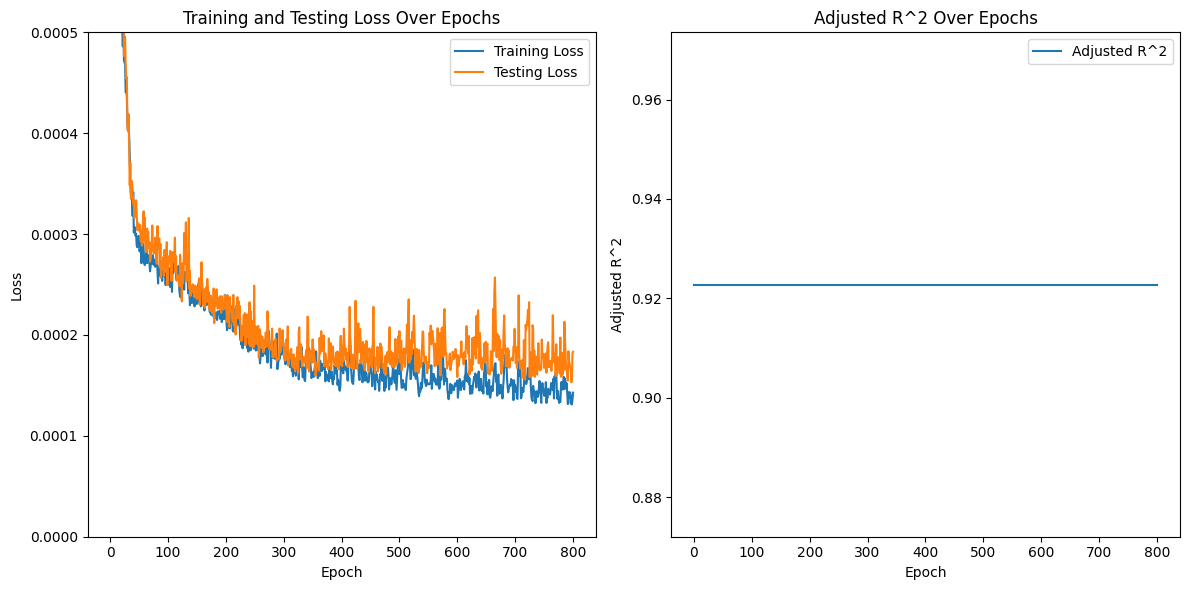

In [81]:

print(f'Final R^2: {r2:.4f}, Adjusted R^2: {adjusted_r2:.4f}')
print(f'Final MAE: {mae_score:.4f}, Adjusted MSE: {mse_score:.4f}')
print('Len: {} Min: {}; Max: {}; Median: {}; Mean {}'.format(len(y_true),min(y_true),max(y_true),median(y_true),mean(y_true)))

# Plotting the training and testing losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.0005)  # Setting the vertical axis limits
plt.title('Training and Testing Loss Over Epochs')
plt.legend()

# Plotting the adjusted R^2
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [adjusted_r2]*num_epochs, label='Adjusted R^2')
plt.xlabel('Epoch')
plt.ylabel('Adjusted R^2')
plt.title('Adjusted R^2 Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

For optimizing the model, we can experiment with different hyperparameters such as learning rate, number of hidden layers, number of neurons per layer, batch size, and number of epochs. Additionally, we can use techniques such as Grid Search or Random Search to systematically explore different hyperparameter combinations.